# Simple Example
This application uses a Flax BNN with stochastic Stein VI to predict a binary class on a simulated sklearn moon-dataset.

In [1]:
import matplotlib.pyplot as plt

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
import jax

from datetime import date

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
from warnings import filterwarnings

from flax import linen as nn
import jax.numpy as jnp

from sklearn.datasets import make_moons

filterwarnings("ignore")
import matplotlib as mpl

cmap = mpl.colormaps["coolwarm"]

import sys, os
sys.path.insert(0, os.path.abspath(".."))
from modules.evaluation_functions.bnn_functions import *

Creating the moon-dataset:

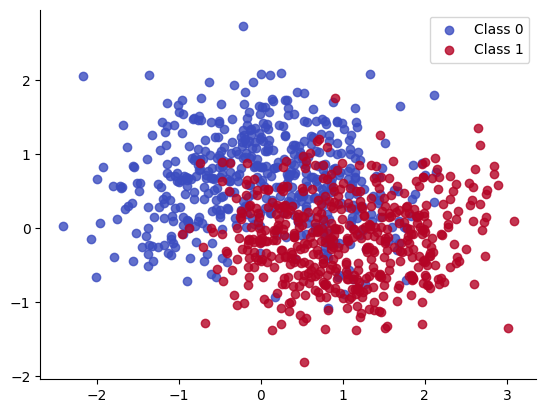

In [2]:
n_samples = 1000
grid = jnp.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T

Xs, Ys = make_moons(noise=0.5, n_samples=n_samples)
for i in range(2):
    plt.scatter(Xs[Ys == i, 0], Xs[Ys == i, 1], color=cmap(float(i)), label=f"Class {i}", alpha=.8)
plt.legend();

In [3]:
Xs_train = Xs[: n_samples // 2 ,:]
Xs_test = Xs[n_samples // 2 :,:]
Ys_train = Ys[: n_samples // 2]
Ys_test = Ys[n_samples // 2 :]

# MLP
Creating the Flax BNN:

In [4]:
# MLP params
hidden_layer_width = 5
n_hidden_layers = 2

class NN(nn.Module):
    n_hidden_layers: int
    layer_width: int

    @nn.compact
    def __call__(self, x):
        for i in range(self.n_hidden_layers):
            x = nn.Dense(features=self.layer_width)(x)
            x = nn.tanh(x)
        return nn.Dense(features=1)(x)

bnn = NN(n_hidden_layers, hidden_layer_width)

Training our model with stochastic Stein VI:

In [5]:
rng_key, eval_key = jax.random.split(rng_key)

def fit_and_eval_single_mlp(key, X_train, Y_train, X_test):
    return fit_and_eval(
        key, bnn, logdensity_fn_of_bnn, X_train, Y_train, X_test, grid, num_steps=400,batch_size_particles = 20, batch_size_data = 32, num_particles=200
    )

Ys_pred_train, Ys_pred_test, ppc_grid_single, _, _ = fit_and_eval_single_mlp(eval_key, Xs_train, Ys_train, Xs_test)

100%|██████████| 400/400 [00:09<00:00, 42.57it/s]


In [6]:
print(f"Train accuracy = {100 * jnp.mean(Ys_pred_train == Ys_train):.2f}%")

Train accuracy = 82.80%


In [7]:
print(f"Test accuracy = {100 * jnp.mean(Ys_pred_test == Ys_test):.2f}%")

Test accuracy = 81.20%


Plotting our results on the train-and test-dataset:

Train-Data:


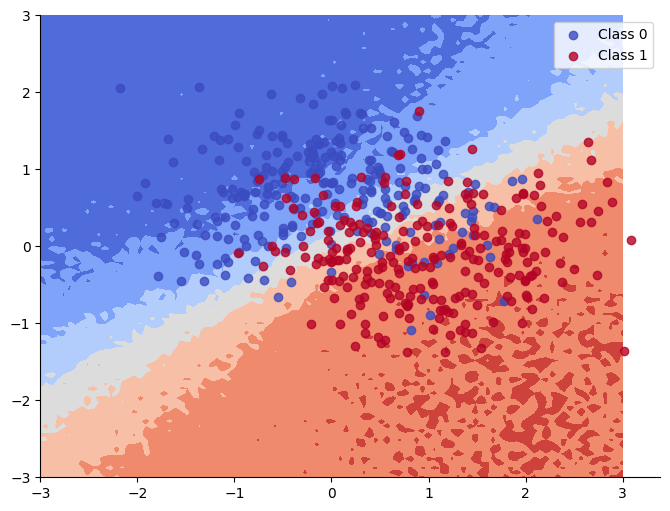

In [8]:
def plot_decision_surfaces_non_hierarchical(train = True):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.contourf(
        grid[:, 0].reshape(100, 100),
        grid[:, 1].reshape(100, 100),
        ppc_grid_single[...].mean(axis=0).reshape(100, 100),
        cmap=cmap,
    )
    if train == True:
        print("Train-Data:")
        for i in range(2):
            ax.scatter(
                Xs_train[Ys_train == i, 0], Xs_train[Ys_train == i, 1], 
                color=cmap(float(i)), label=f"Class {i}", alpha=.8)
    else:
        print("Test-Data:")
        for i in range(2):
            ax.scatter(
                Xs_test[Ys_test == i, 0], Xs_test[Ys_test == i, 1], 
                color=cmap(float(i)), label=f"Class {i}", alpha=.8)
    ax.legend()

plot_decision_surfaces_non_hierarchical()

Test-Data:


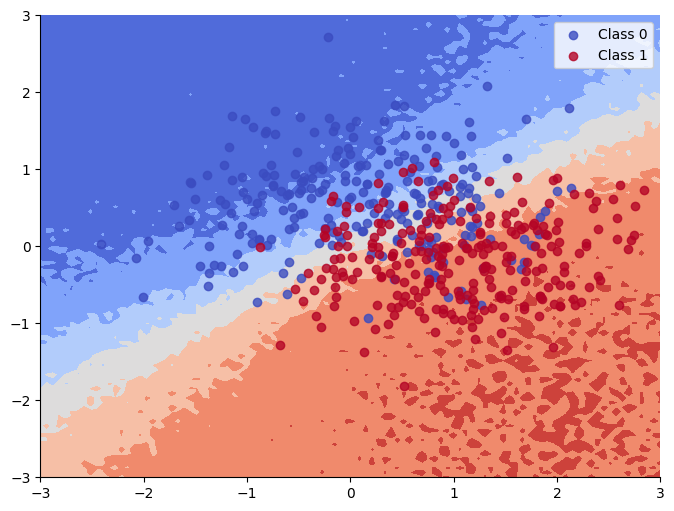

In [9]:
plot_decision_surfaces_non_hierarchical(train=False)